In [1]:
%config Completer.use_jedi = False

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv(
    '../resources/book_sales.csv',
    parse_dates = ['Date'],
    index_col='Date'
).drop('Paperback', axis=1)


In [5]:
df['Time'] = np.arange(len(df.index))

In [6]:
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


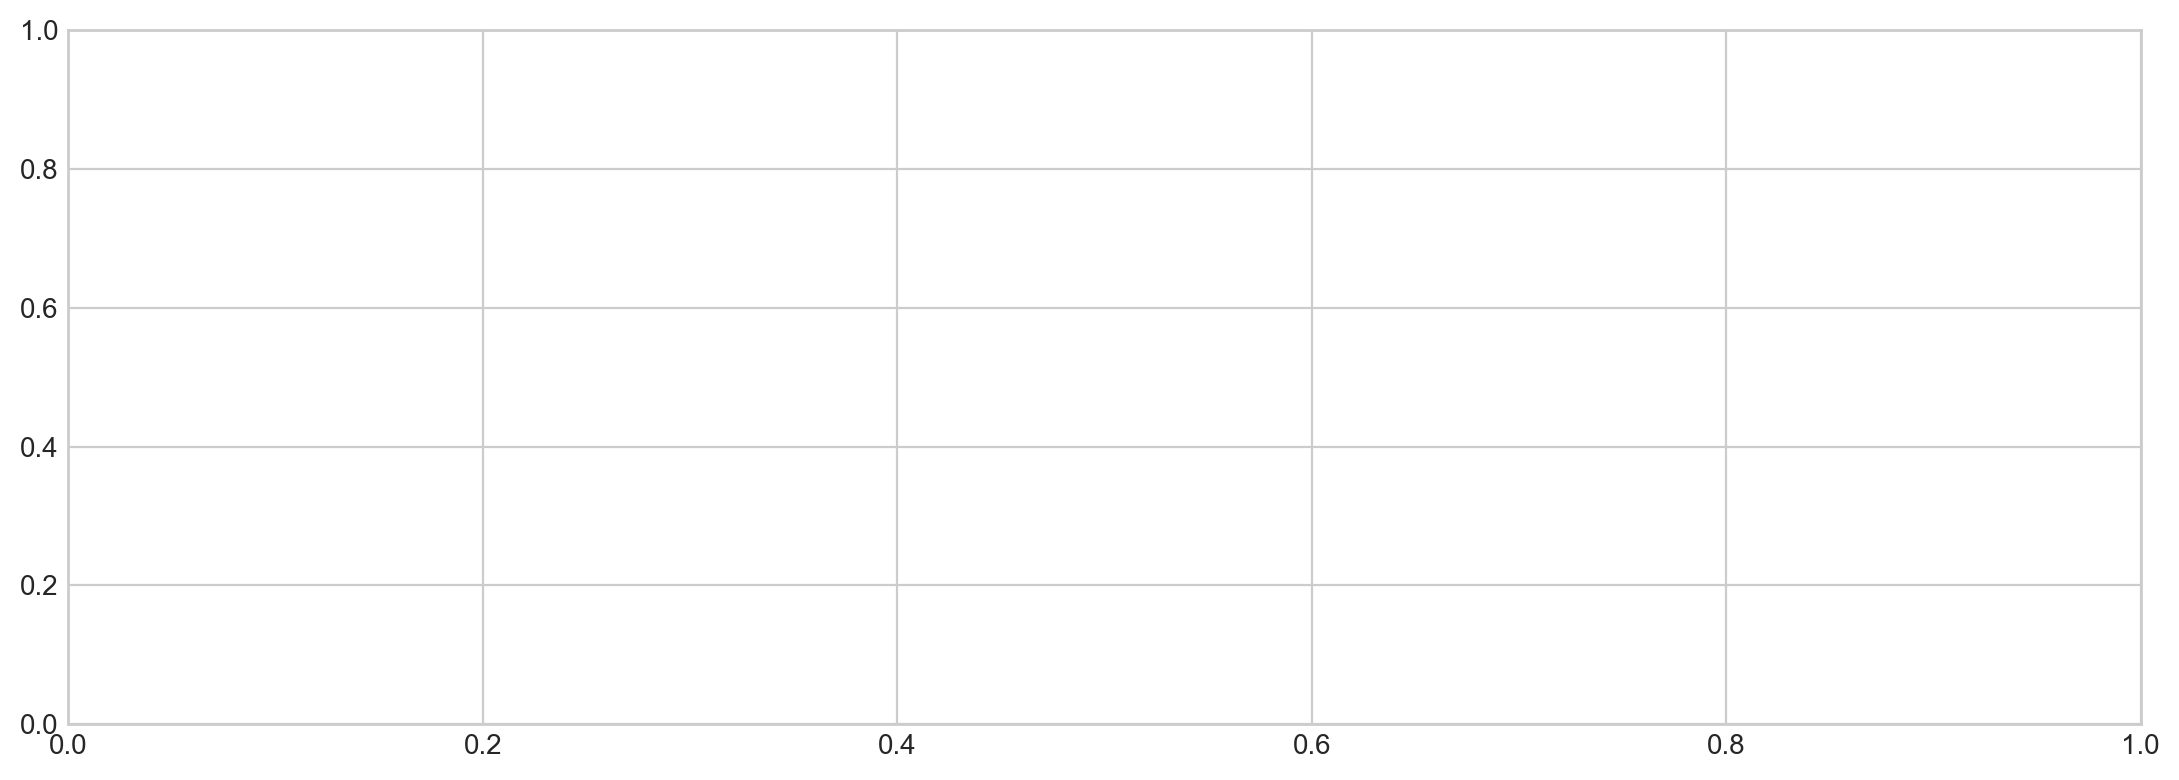

In [7]:
fig, ax = plt.subplots()

In [8]:
ax.plot('Time', 'Hardcover', data=df, color='0.90')

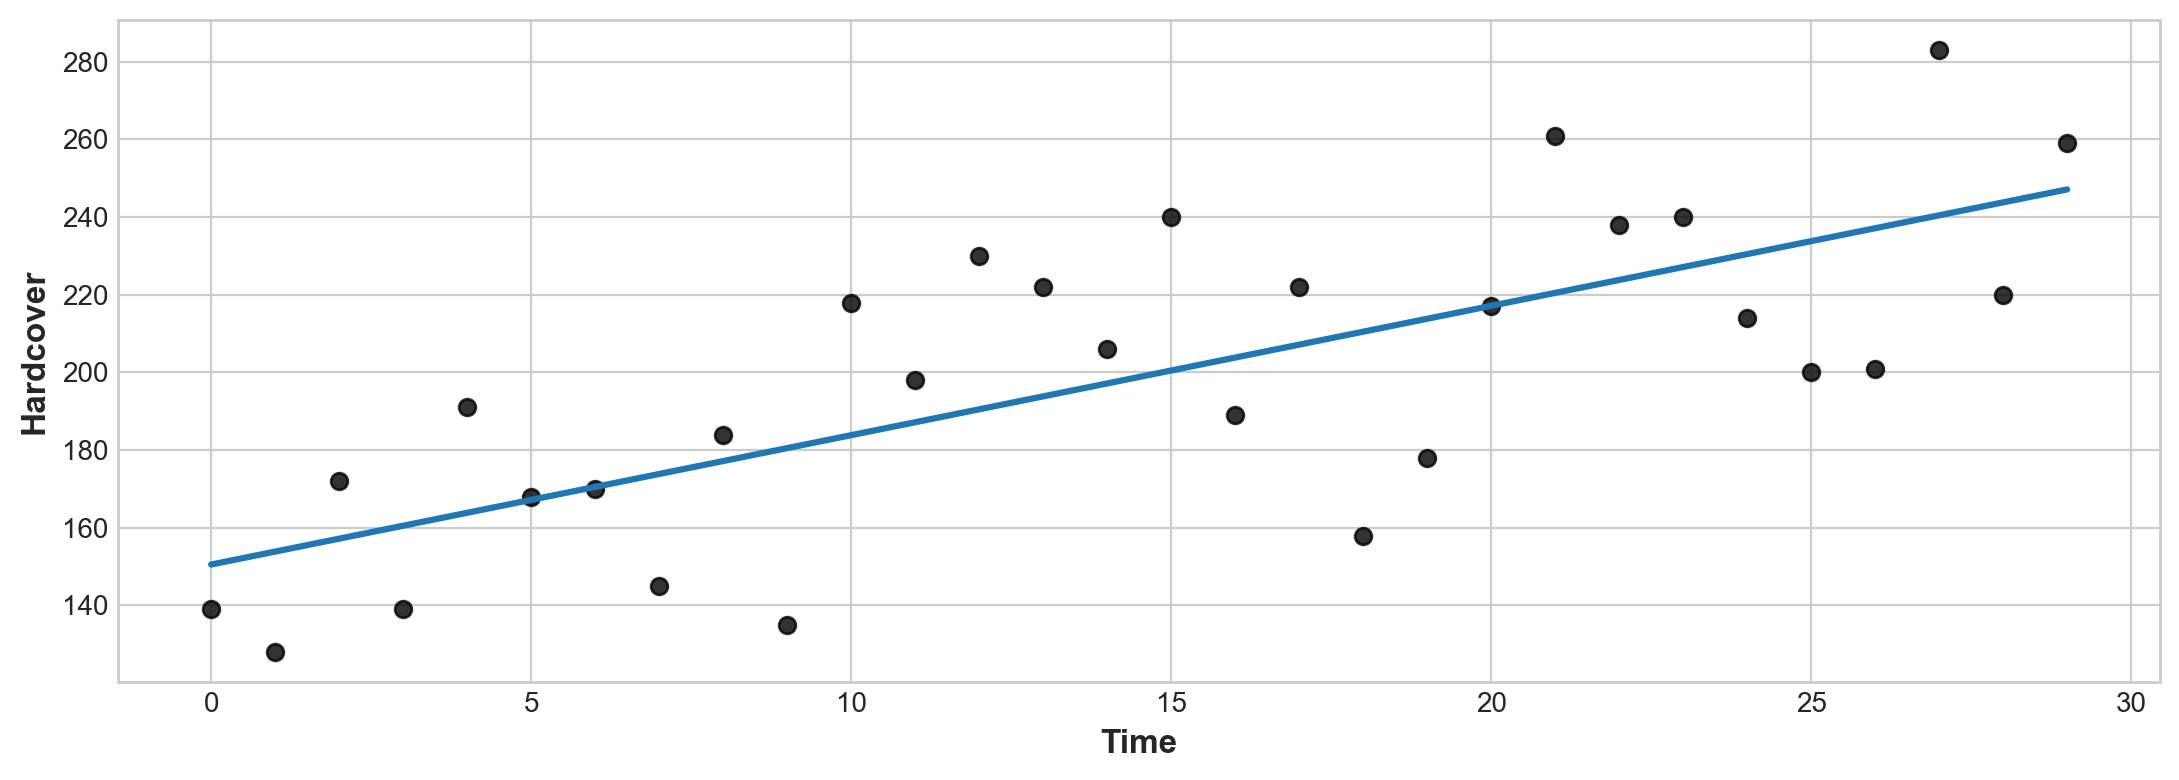

In [9]:
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=1, scatter_kws=dict(color='0.0'))

In [10]:
# ax.set_title('Time Plot of Hardcover Sales')

In [11]:
df['Lag_1'] = df['Hardcover'].shift(3)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

In [12]:
df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,NaN
2000-04-03,172,NaN
2000-04-04,139,139.0
2000-04-05,191,128.0


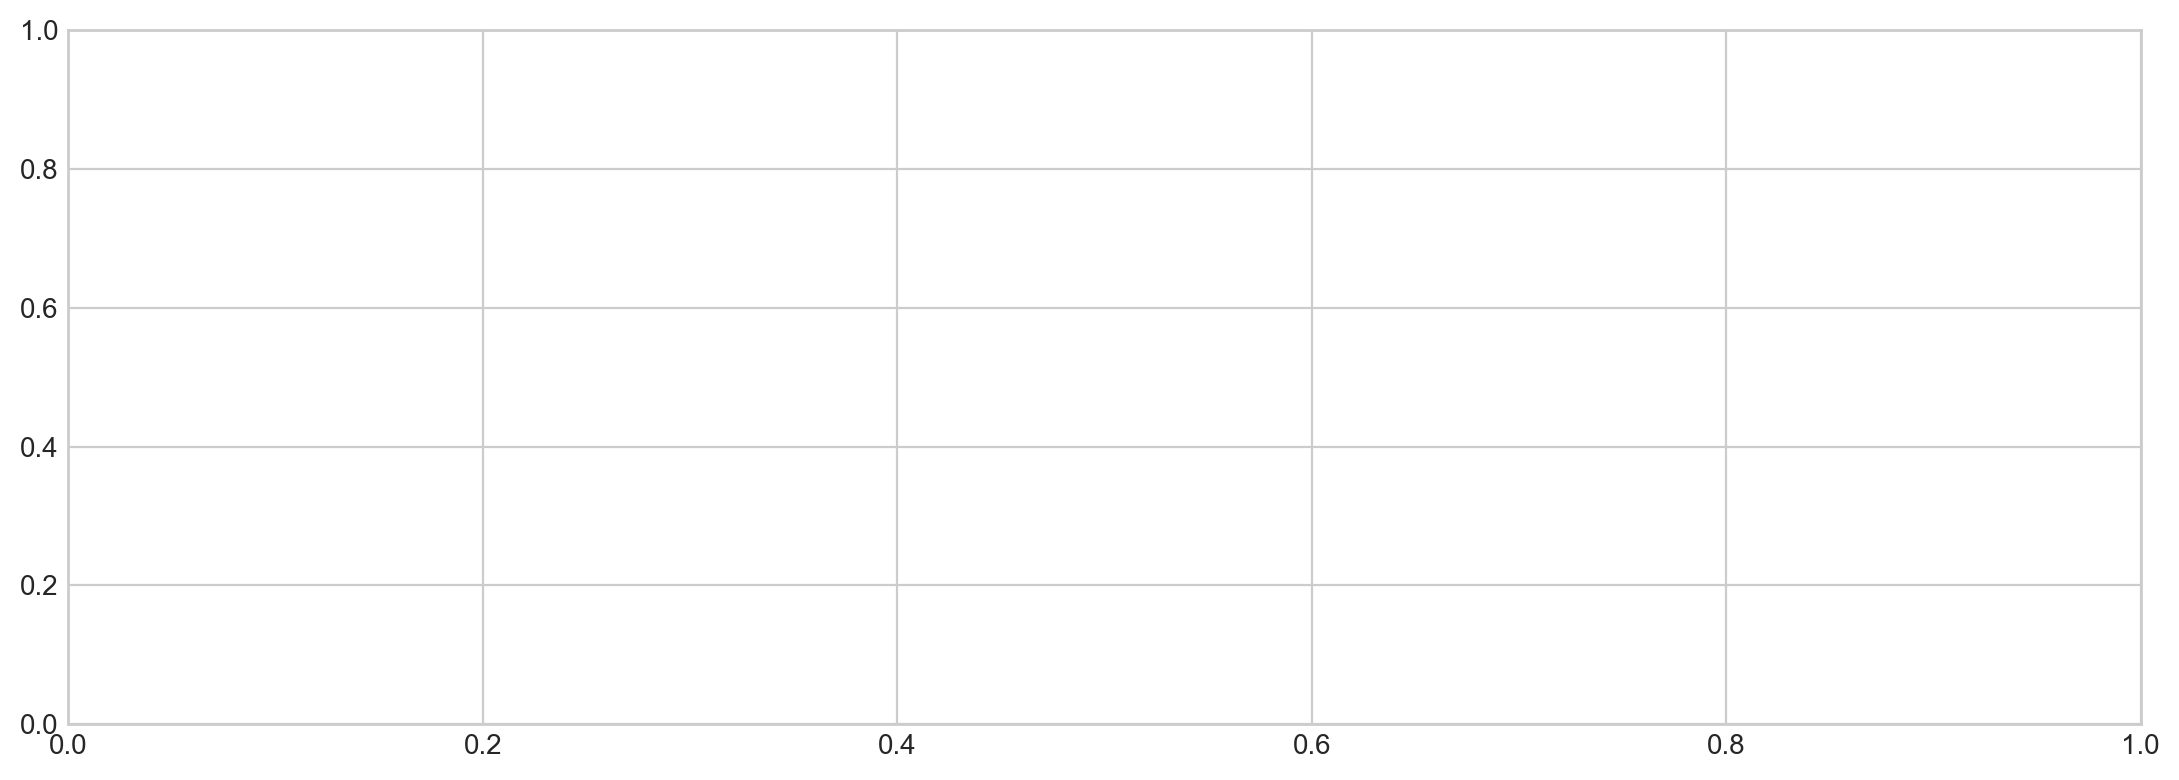

In [13]:
fig, ax = plt.subplots()

Text(0.5, 1.0, 'Lag Plot of Hardcover Sales')

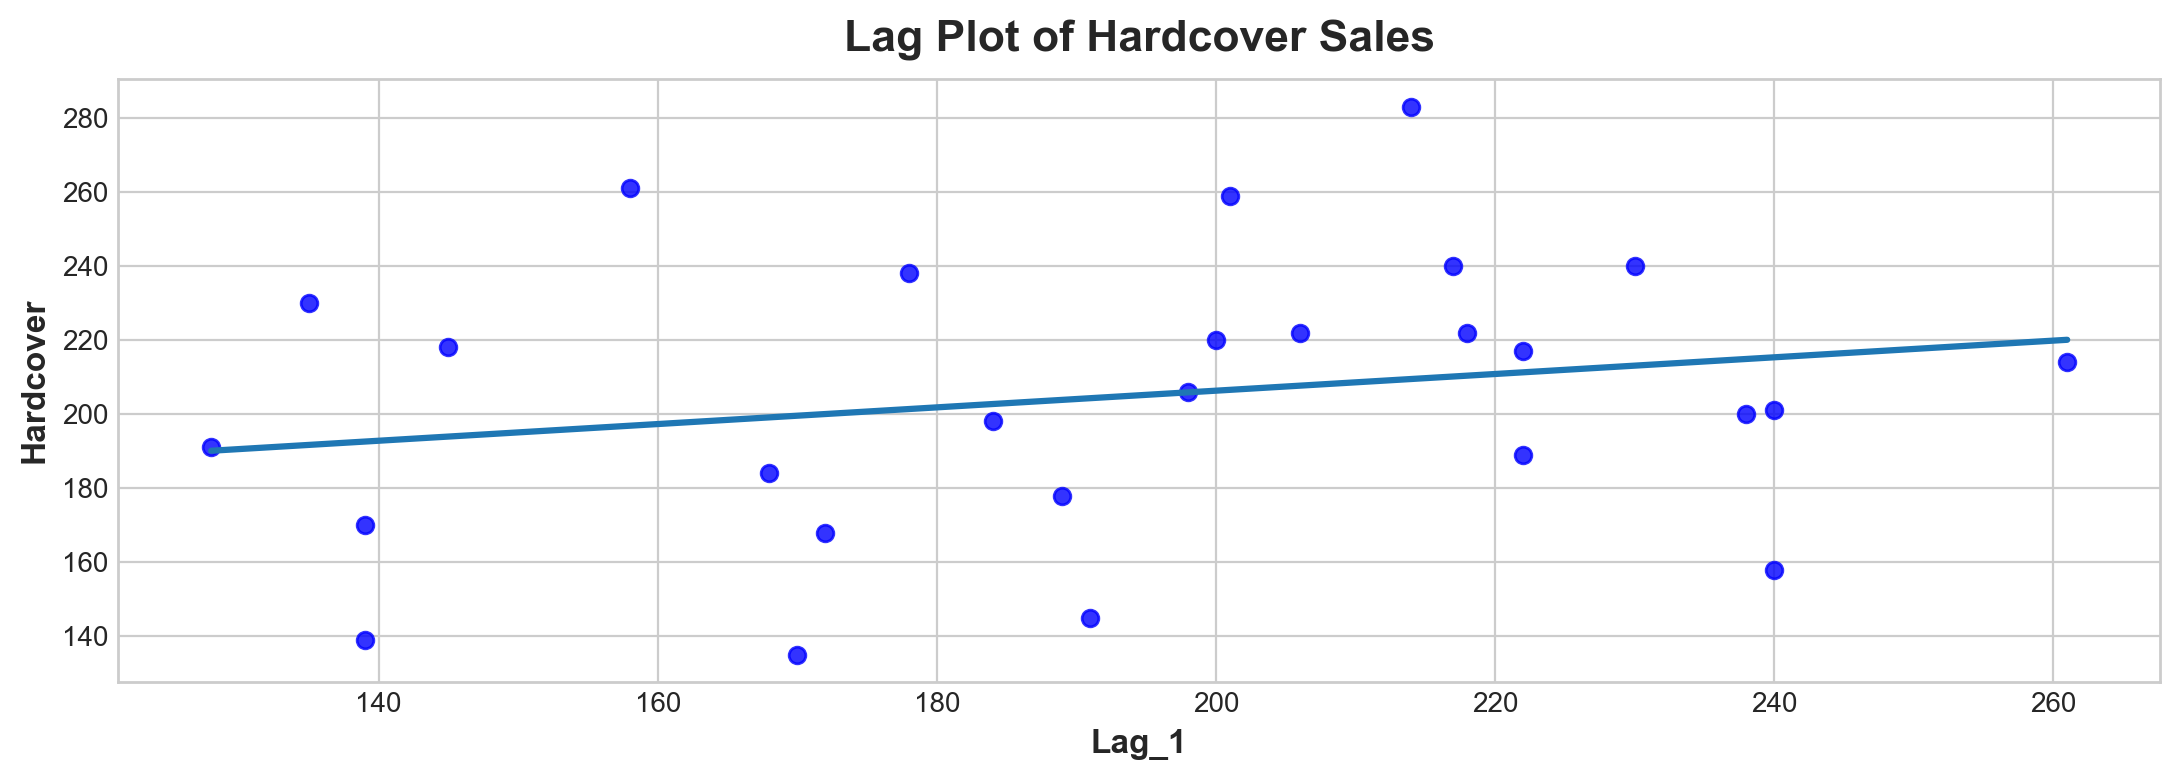

In [14]:
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='b'))
# ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales')

TUNNEL DATA

In [3]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [4]:
tunnel = pd.read_csv('../resources/tunnel.csv', parse_dates=['Day'], index_col='Day')
# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()
from sklearn.linear_model import LinearRegression
tunnel_copy = tunnel.copy()

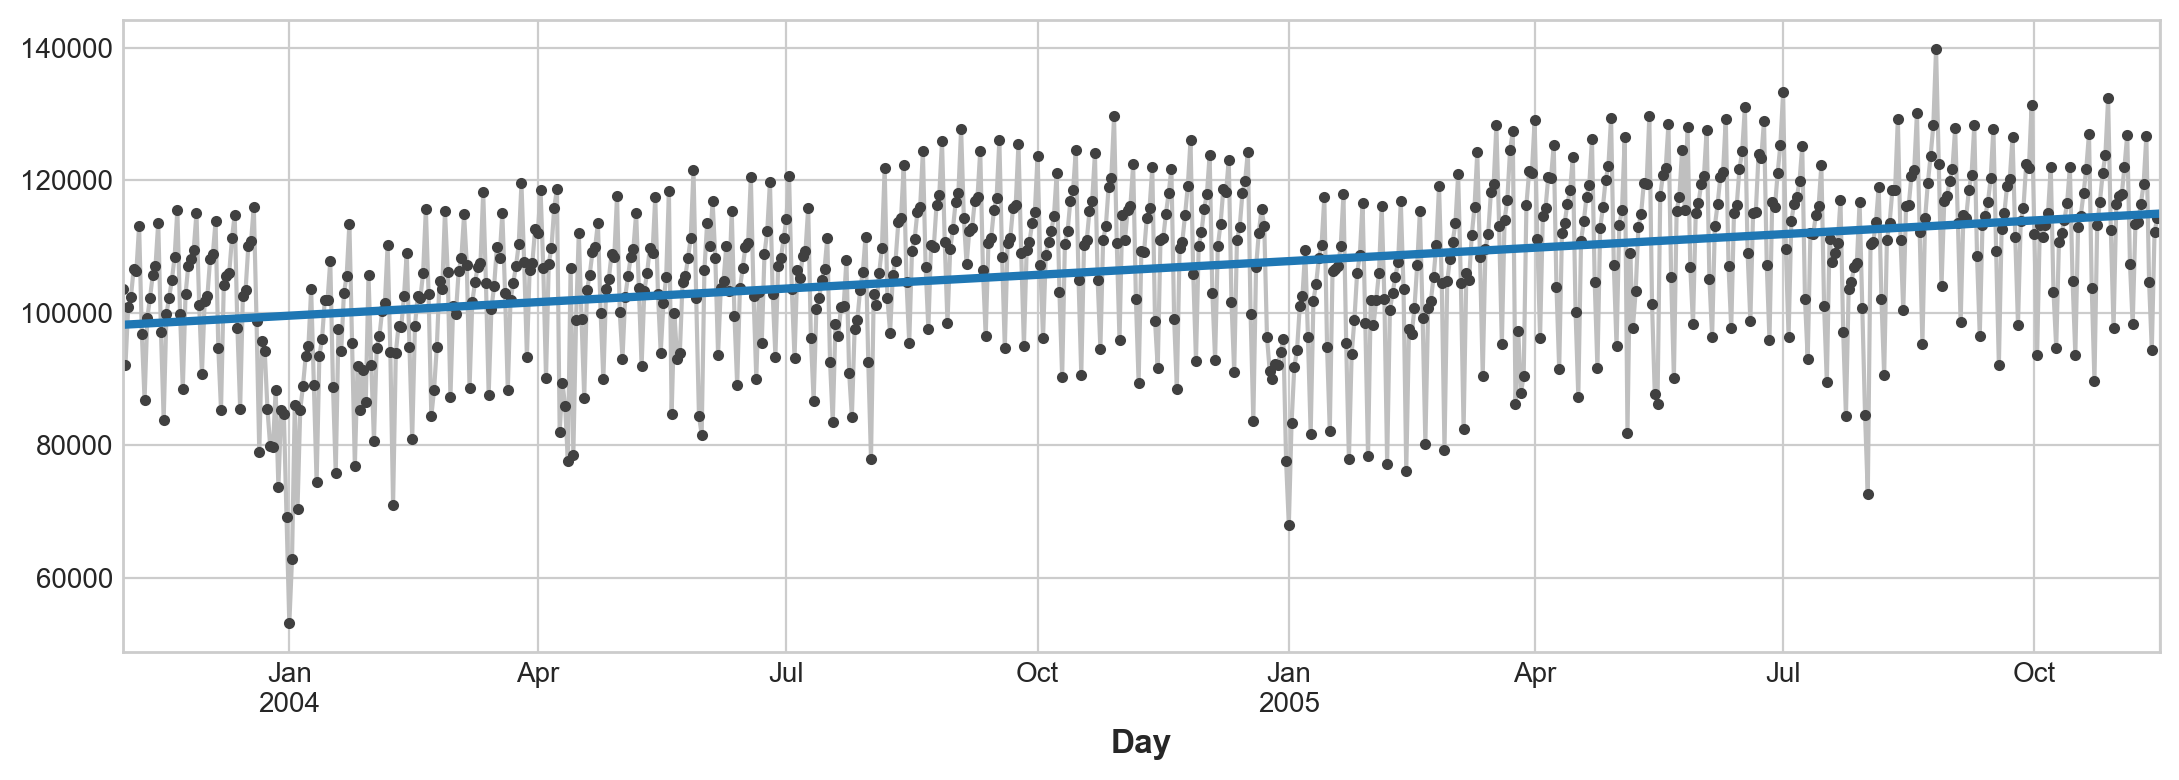

In [15]:

tunnel['Time'] = np.arange(len(tunnel.index))

X = tunnel.loc[:, ['Time']] # time-step feature
y = tunnel.loc[:, ['NumVehicles']] # target
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X)[:,0], index=X.index)


ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)



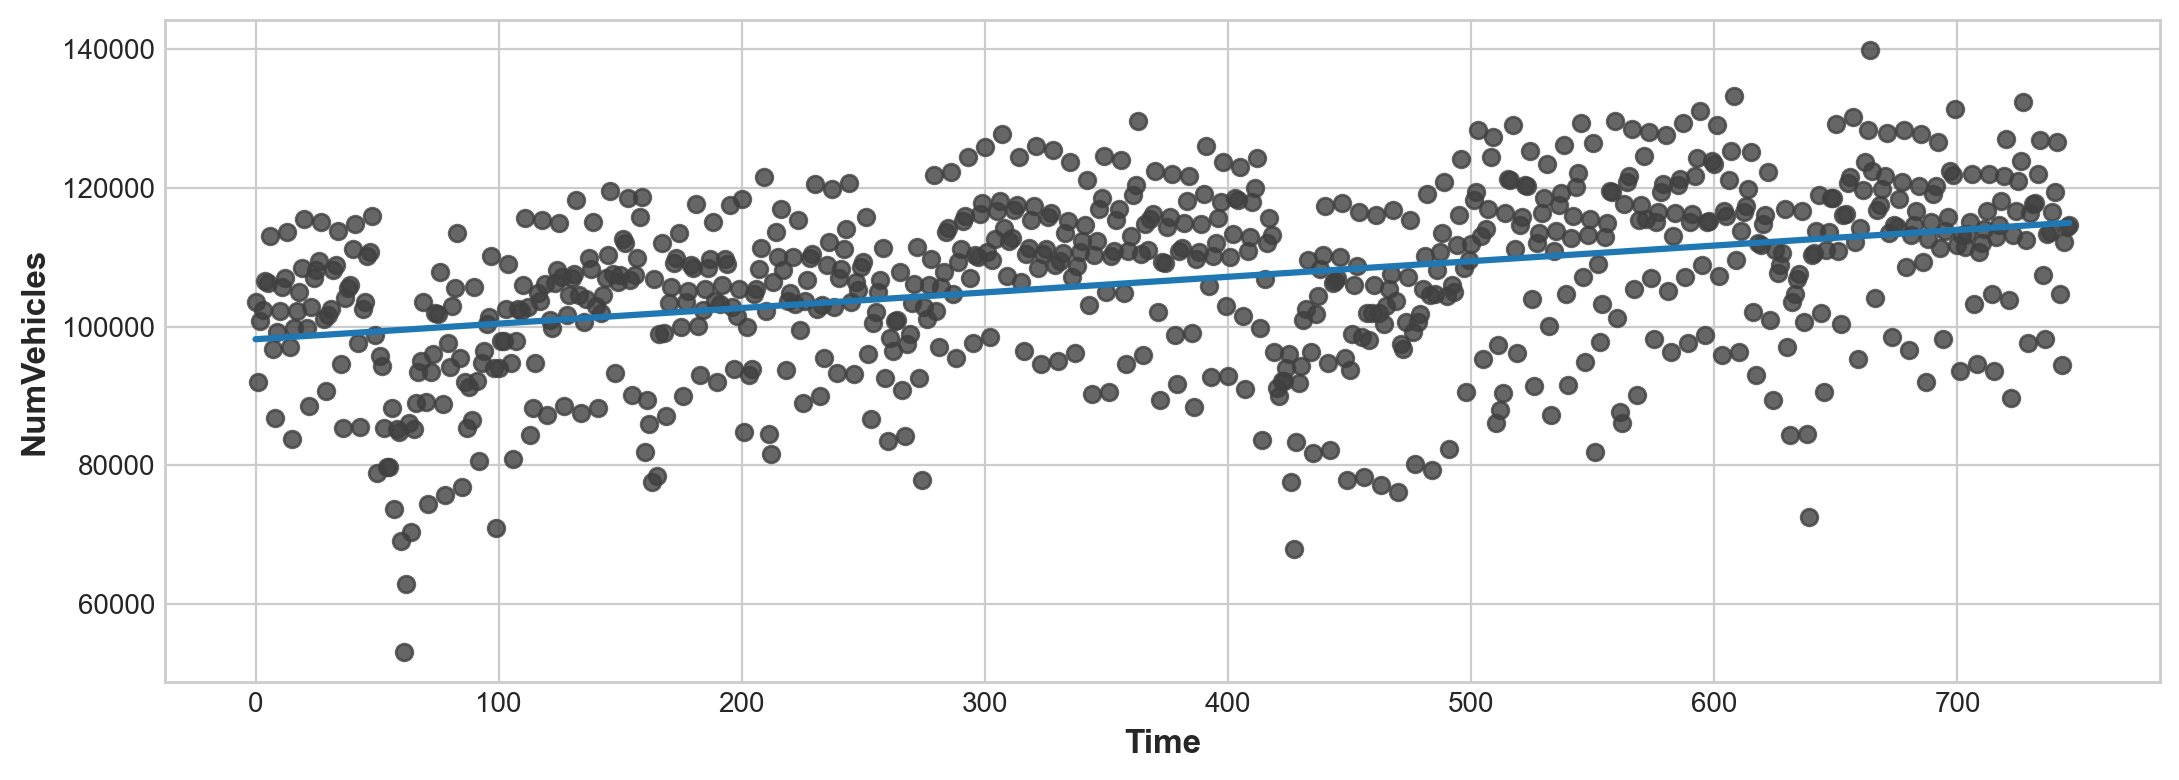

In [79]:
ax = sns.regplot(x='Time', y='NumVehicles', data=tunnel, ci=None, scatter_kws=dict(color='0.25'))

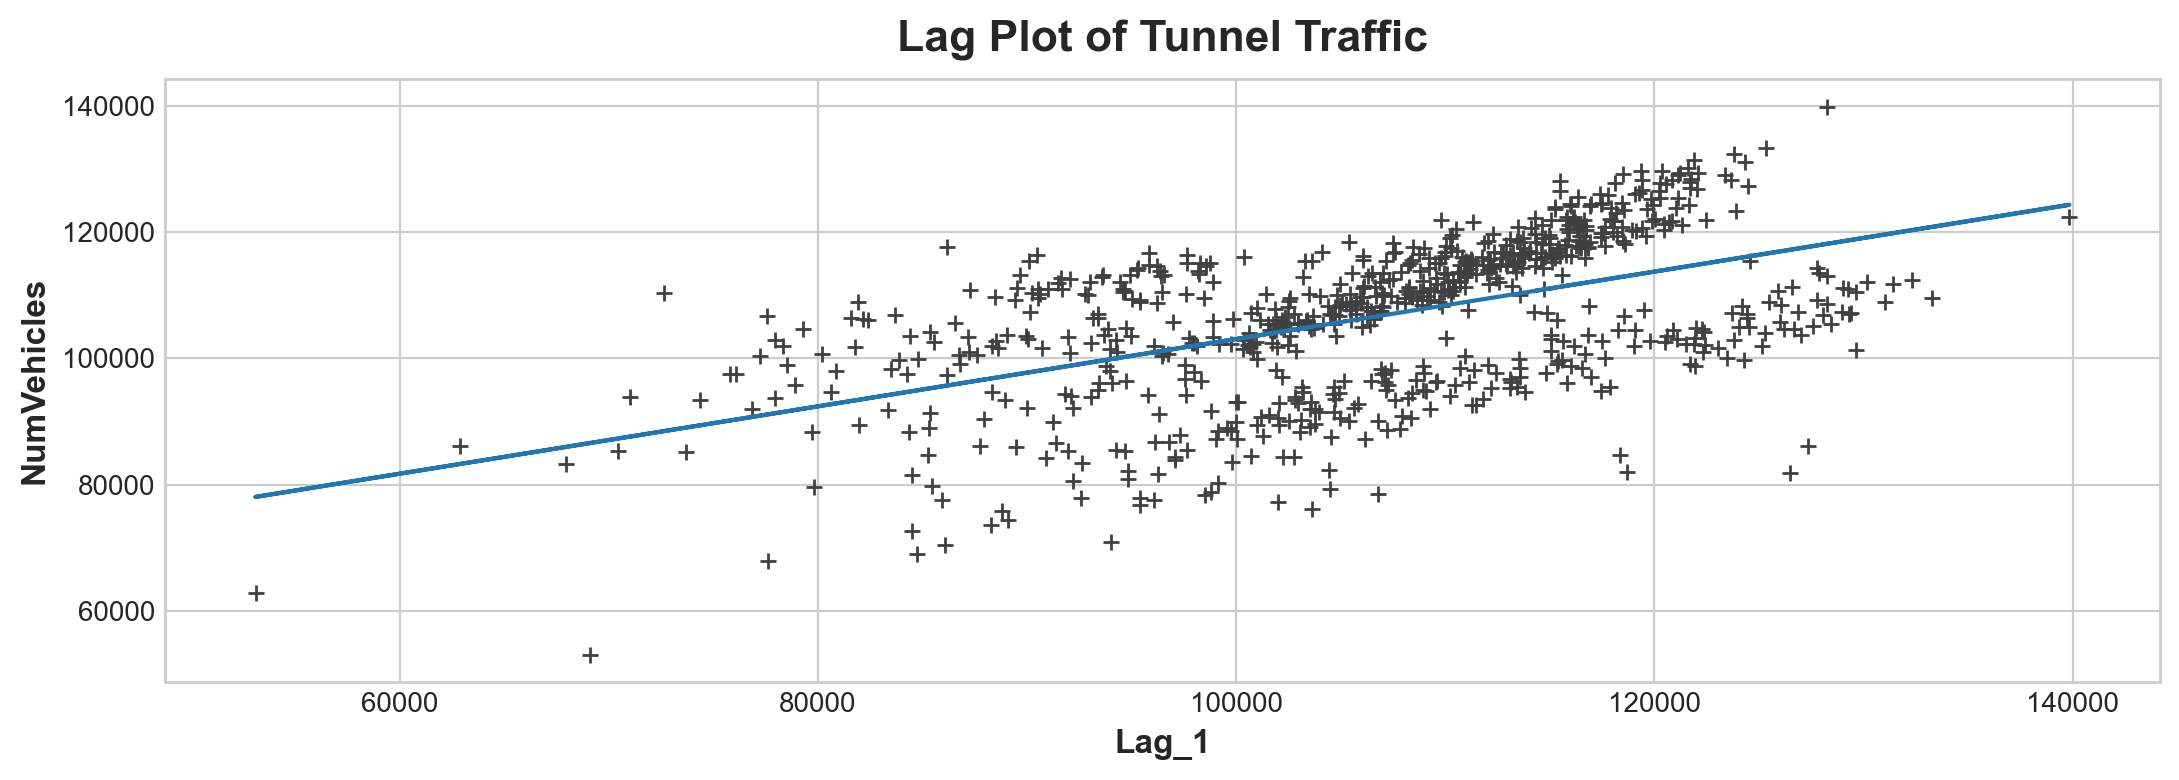

In [13]:
tunnel_copy['Leg_1'] = tunnel_copy['NumVehicles'].shift(1)

new_X = tunnel_copy.loc[:, ['Leg_1']] # lag feature
new_y = tunnel_copy.loc[:, 'NumVehicles'] # target
new_X.dropna(inplace=True)
new_y, new_X = new_y.align(new_X, join='inner')
model = LinearRegression()
model.fit(new_X, new_y)
y_pred = pd.Series(model.predict(new_X), index=new_X.index)




fig, ax = plt.subplots() # creates a figure with only one axes for a single plot
ax.plot(new_X, new_y, '+', color='0.25')
ax.plot(new_X, y_pred)


ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');


# TRENDS

In [47]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("../resources/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()
tunnel.tail()

,NumVehicles
Day,
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165
2005-11-15,114296
2005-11-16,114690


<Axes: xlabel='Day'>

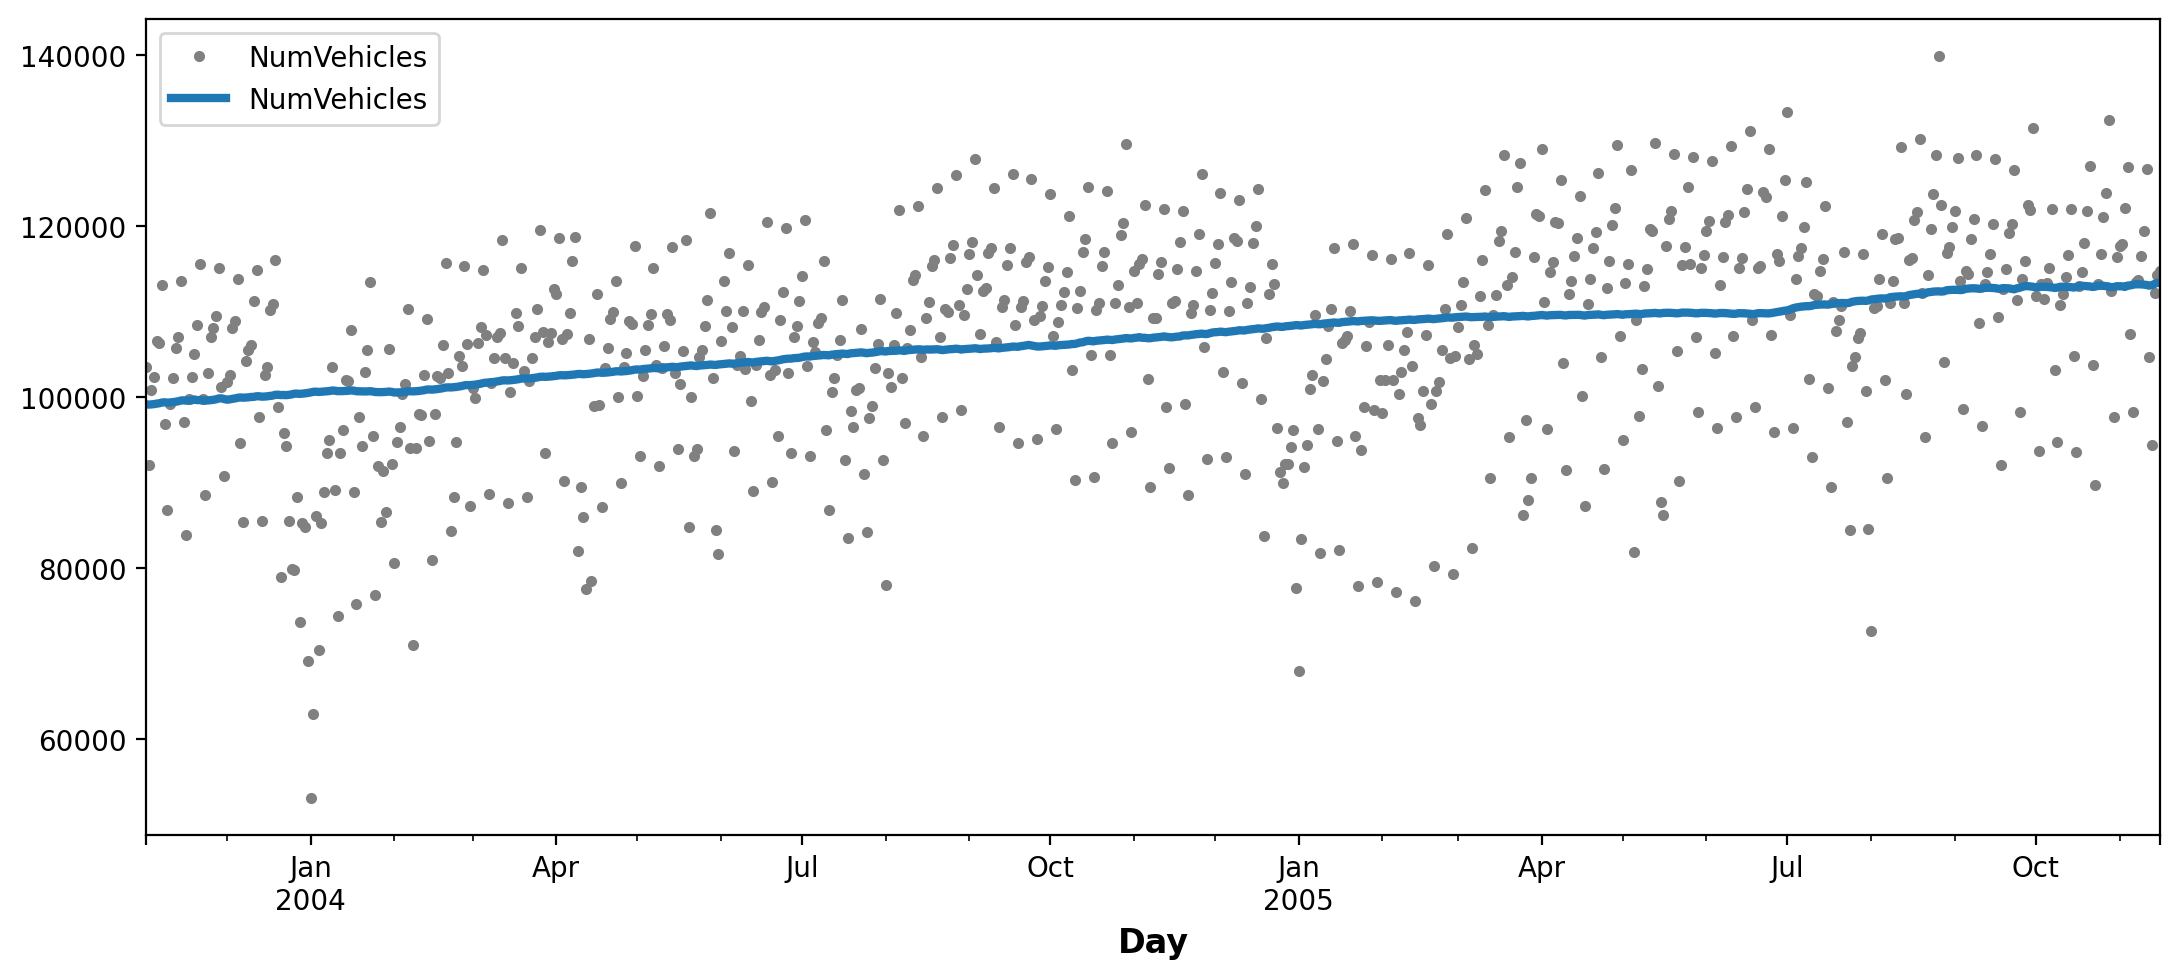

In [30]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True, # puts the average at the center of the window
    
    min_periods=183,  # choose about half the window size
).mean()   

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax,
    linewidth=3
)

In [32]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


In [34]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles']
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)

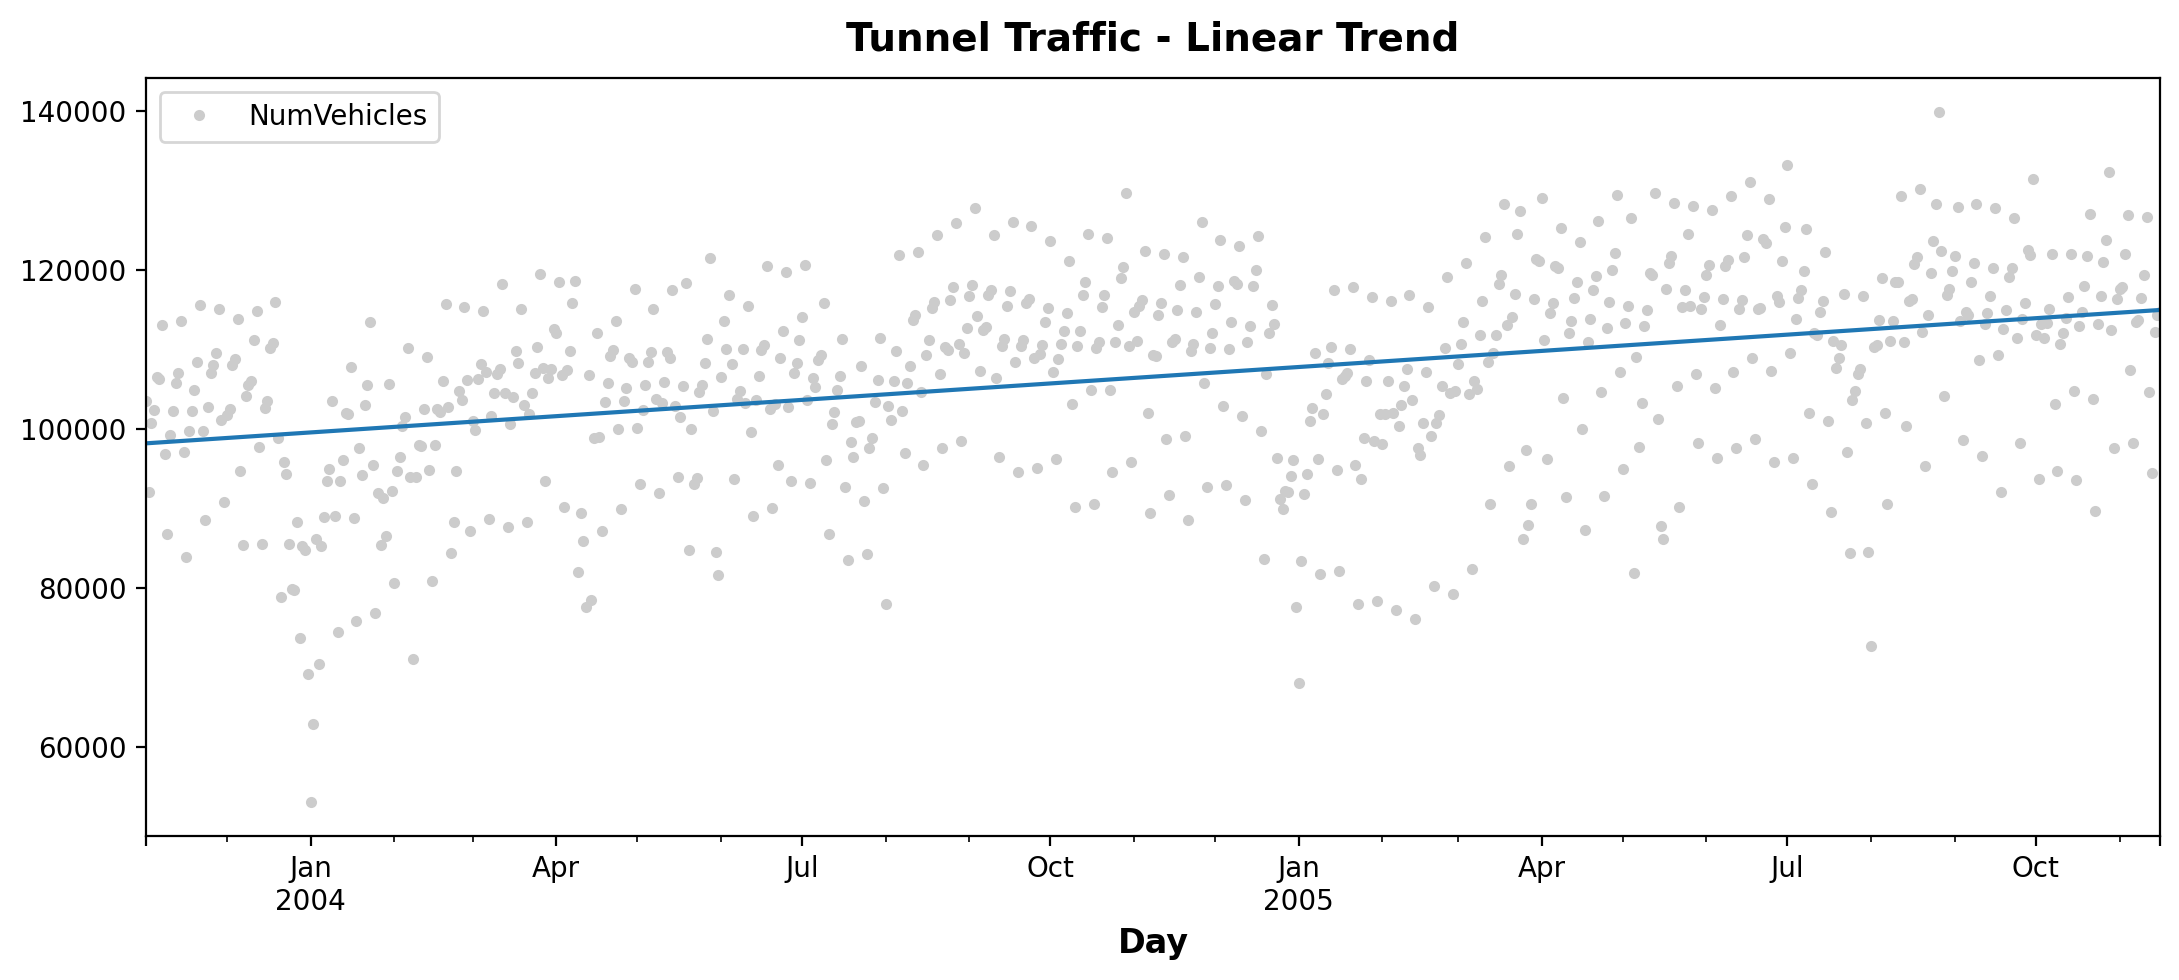

In [41]:
ax = tunnel.plot(style='.', color='0.80', title='Tunnel Traffic - Linear Trend')
ax = y_pred.plot(ax=ax)

The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

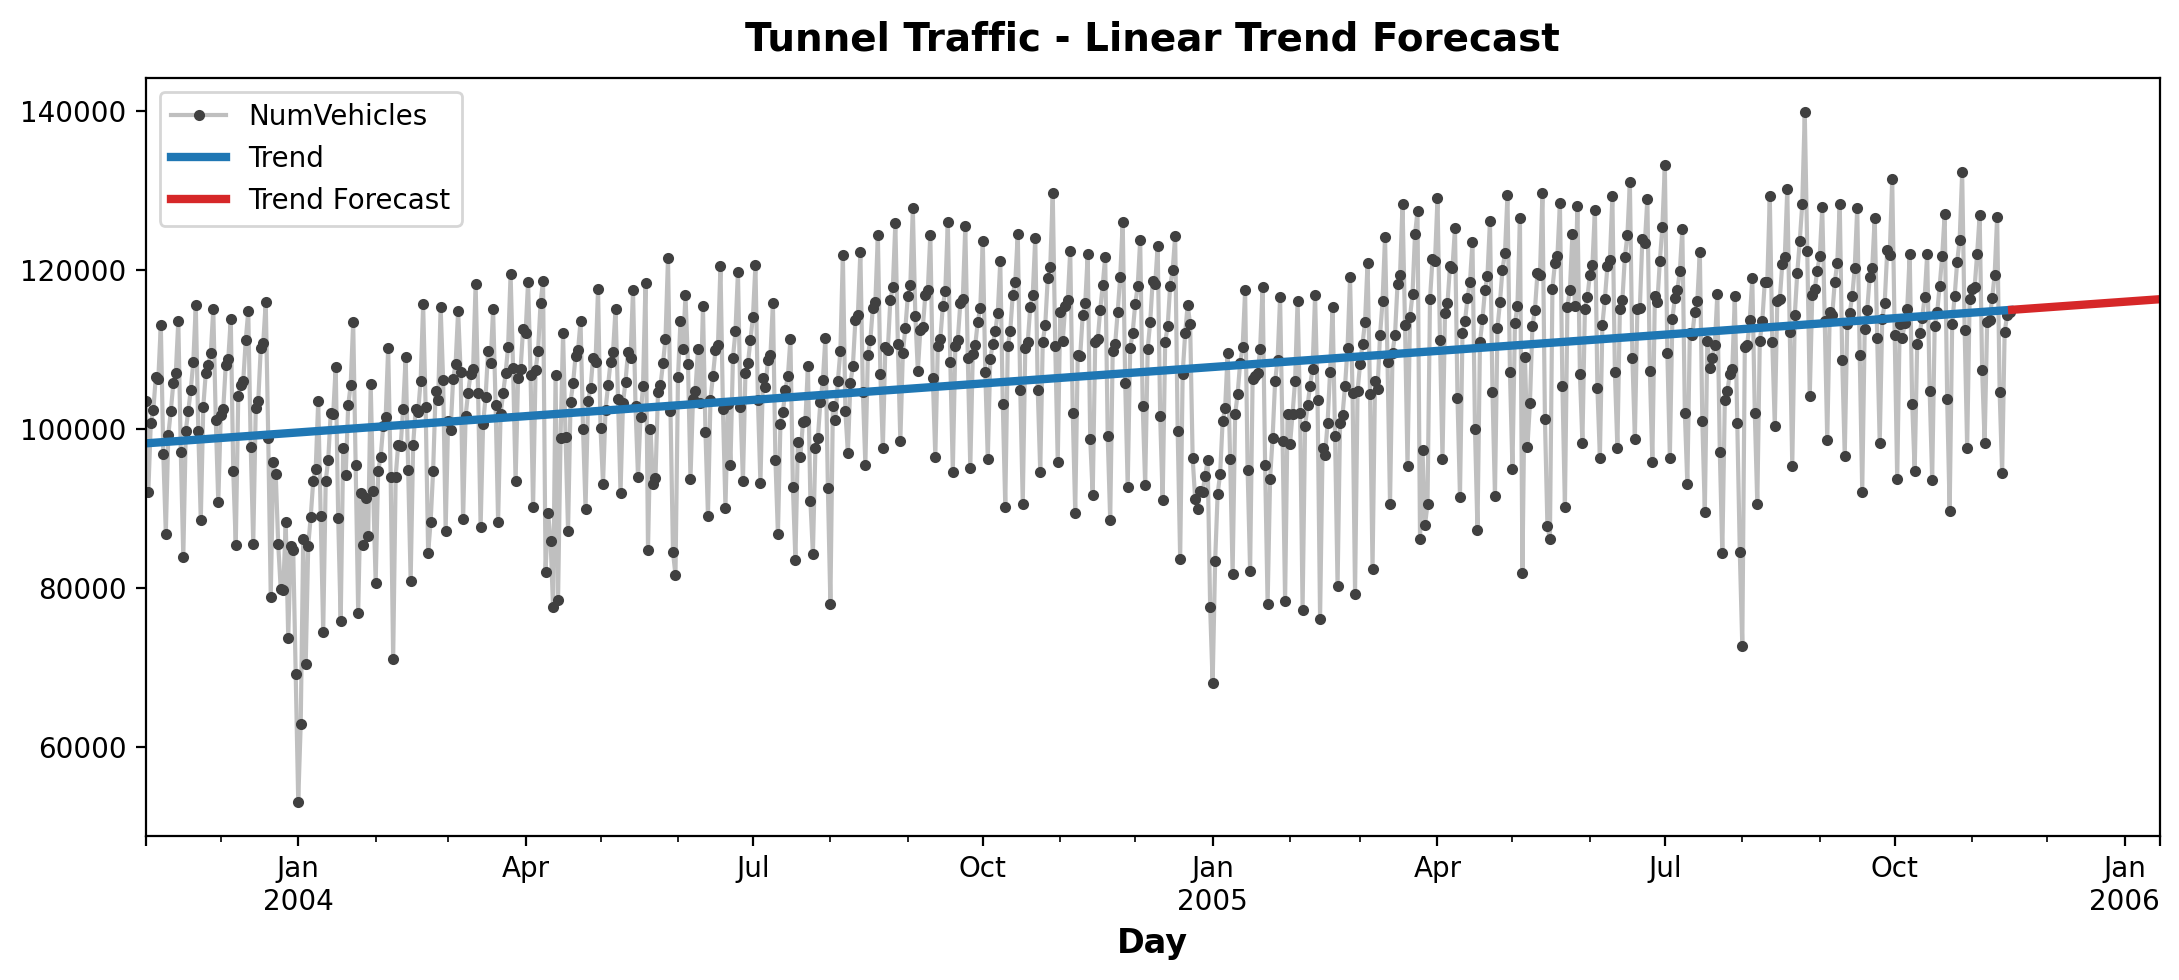

In [53]:
X_fore = dp.out_of_sample(steps=60)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
ax = tunnel.plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()

# Seasonality

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

plt.style.use('seaborn-v0_8')

# Using this rc function we can set some parameters on different components like, figure, lines, font, etc.
#  plt.rc('group name goes here', **kwargs_for_that_group)
plt.rc('figure', autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


In [46]:
def seasonal_plot(X, y, period, freq, ax=None):
    
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    # ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv("../resources/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")


In [96]:
X = tunnel.copy()

X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

<Axes: xlabel='dayofyear', ylabel='NumVehicles'>

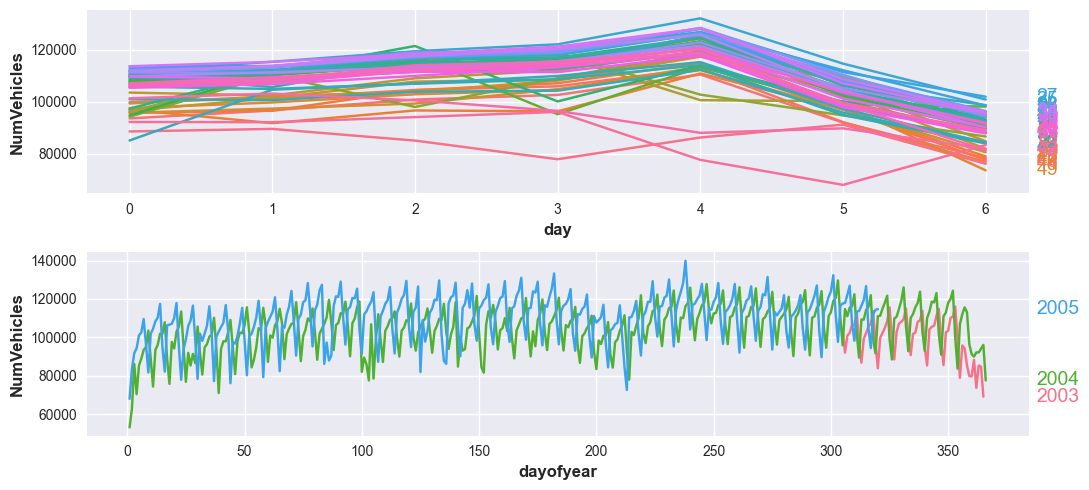

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
seasonal_plot(X, y='NumVehicles', period='week',  freq='day', ax=ax1)
seasonal_plot(X, y='NumVehicles', period='year',  freq='dayofyear', ax=ax2)


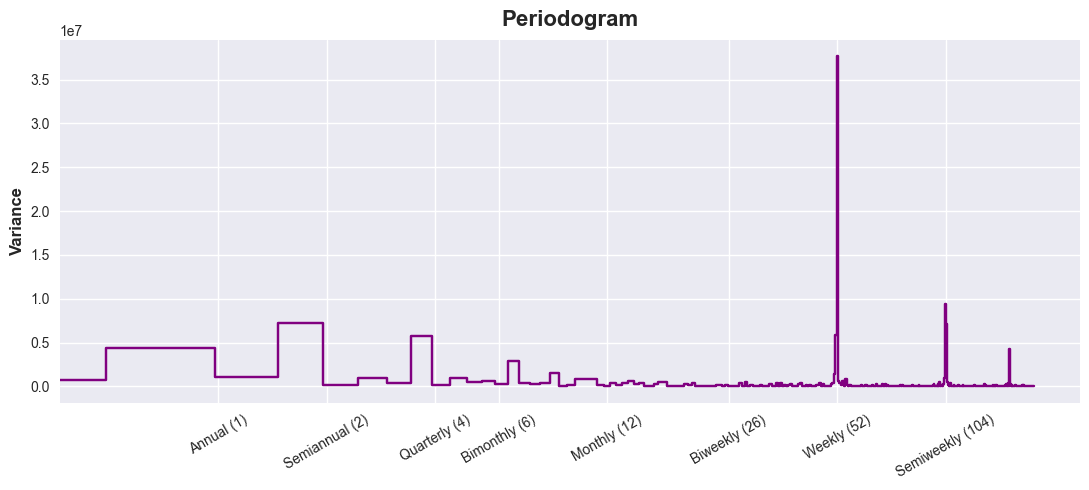

In [98]:
plot_periodogram(tunnel.NumVehicles);




The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between Bimonthly (6) and Monthly (12), so let's use 10 Fourier pairs.

We'll create our seasonal features using DeterministicProcess, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":


In [99]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier_10 = CalendarFourier(freq='A', order=10)
fourier_6 = CalendarFourier(freq='A', order=6)
dp_10 = DeterministicProcess(
    index=tunnel.index,
    constant=True,         # dummy feature for bias (y-intercept)
    order=1,               # trend (order 1 means linear)
    seasonal=True,         # weekly seasonality (indicators)
    additional_terms=[fourier_10], # annual seasonality (fourier)
    drop=True              # drop terms to avoid collinearity
)
dp_6 = DeterministicProcess(
    index=tunnel.index,
    constant=True,         # dummy feature for bias (y-intercept)
    order=1,               # trend (order 1 means linear)
    seasonal=True,         # weekly seasonality (indicators)
    additional_terms=[fourier_6], # annual seasonality (fourier)
    drop=True              # drop terms to avoid collinearity
)


# X = dp.in_sample()
# X

In [102]:
X_10 = dp_10.in_sample()
X_6 = dp_6.in_sample()

In [103]:
X_10

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-11-12,1.0,743.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.758306,0.651899,...,0.899631,0.436651,0.255353,0.966848,-0.566702,0.823923,-0.994218,0.107381,-0.729558,-0.683919
2005-11-13,1.0,744.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.746972,0.664855,...,0.939856,0.341571,0.369725,0.929141,-0.448229,0.893919,-0.965740,0.259512,-0.835925,-0.548843
2005-11-14,1.0,745.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.735417,0.677615,...,0.970064,0.242850,0.478734,0.877960,-0.321270,0.946988,-0.914128,0.405426,-0.917584,-0.397543


With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

In [107]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)



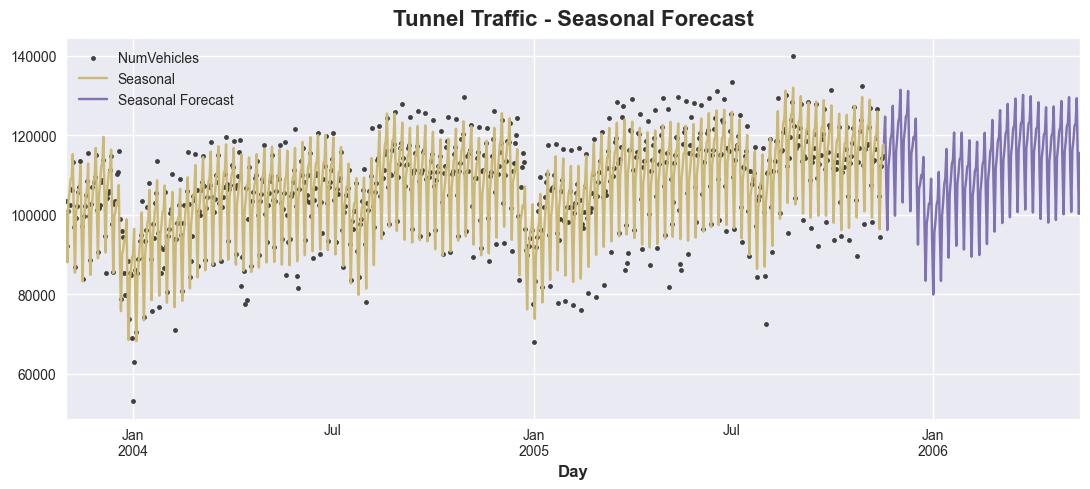

In [109]:
model.fit(X_10, y)
y_10_pred = pd.Series(model.predict(X_10), index=X_10.index)                   
X_10_fore = dp_10.out_of_sample(steps=180)
y_10_fore = pd.Series(model.predict(X_10_fore), index=X_10_fore.index)


ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_10_pred.plot(ax=ax, label="Seasonal", color='C4')
ax = y_10_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

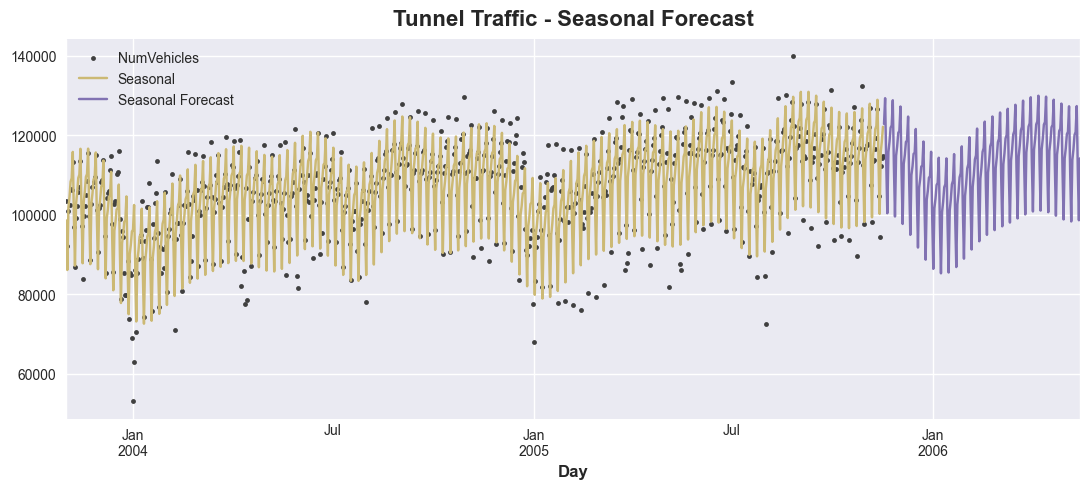

In [110]:
model.fit(X_6, y)
y_6_pred = pd.Series(model.predict(X_6), index=X_6.index)                   
X_6_fore = dp_6.out_of_sample(steps=180)
y_6_fore = pd.Series(model.predict(X_6_fore), index=X_6_fore.index)


ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_6_pred.plot(ax=ax, label="Seasonal", color='C4')
ax = y_6_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

# Serial Dependency (Time Series as Features)

In [111]:
import pandas as pd

In [113]:
# reserve = pd.read_csv(
#     '../resources/reserve.csv',
#     parse_dates = {'Date': ['Year','Month','Day']},
#     index_col='Date'
# )

# reserve.head(20)

,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
Date,,,,,,,
1954-07-01,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1954-08-01,NaN,NaN,NaN,1.22,NaN,6.0,NaN
1954-09-01,NaN,NaN,NaN,1.06,NaN,6.1,NaN
1954-10-01,NaN,NaN,NaN,0.85,8.0,5.7,NaN
1954-11-01,NaN,NaN,NaN,0.83,NaN,5.3,NaN
1954-12-01,NaN,NaN,NaN,1.28,NaN,5.0,NaN
1955-01-01,NaN,NaN,NaN,1.39,11.9,4.9,NaN
1955-02-01,NaN,NaN,NaN,1.29,NaN,4.7,NaN
1955-03-01,NaN,NaN,NaN,1.35,NaN,4.6,NaN


In [115]:
y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')

In [118]:
# laged_data = pd.DataFrame({
#     'original': y,
#     'lag_1': y.shift(1),
#     'lag_2': y.shift(2)
# })
# laged_data.head(20)

,original,lag_1,lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1
1954-12,5.0,5.3,5.7
1955-01,4.9,5.0,5.3
1955-02,4.7,4.9,5.0
1955-03,4.6,4.7,4.9


By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use y_lag_1 and y_lag_2 as features to predict the target y. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

### Example - Flu Trends

The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(12, 5), autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10
)

plot_params = dict(
    color='0.75',
    style='.',
    markeredgecolor='0.25',
    markerfacecolor='0.25'
)

### LAG FUNCS

In [128]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax



def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [142]:
flu_trends = pd.read_csv(
    '../resources/flu-trends.csv'
)
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


<Axes: title={'center': 'Flu Visits'}, xlabel='Week'>

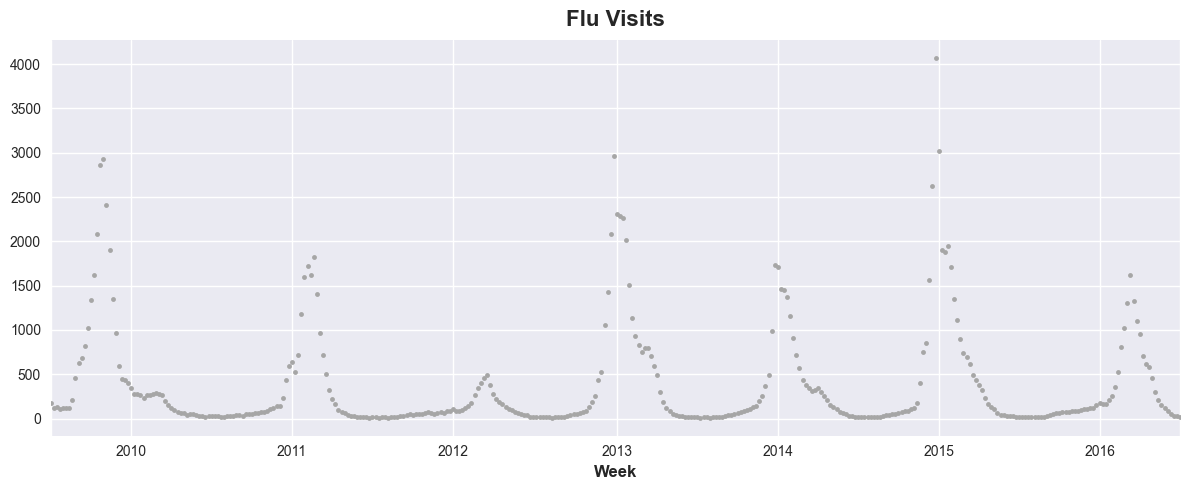

In [155]:
flu_trends.FluVisits.plot(title='Flu Visits', style='.', color='.65')

Our Flu Trends data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

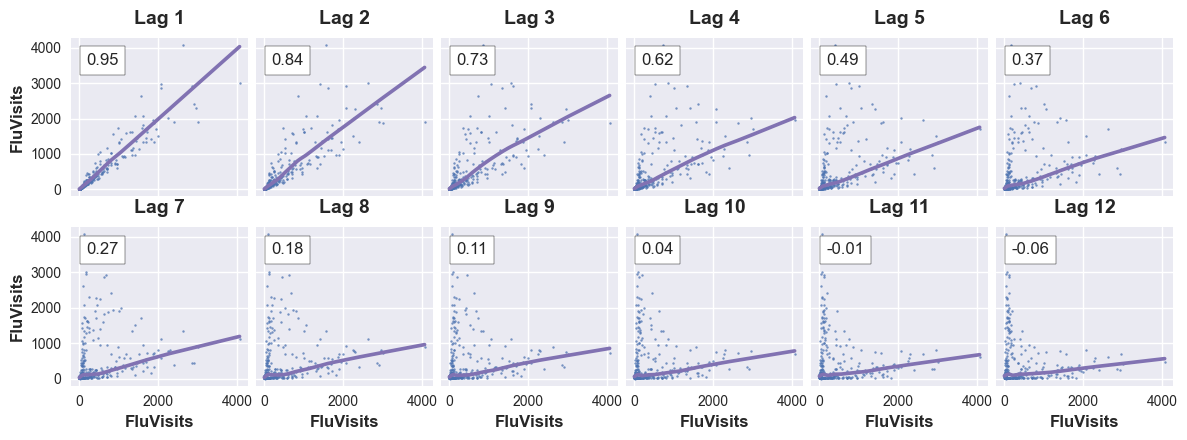

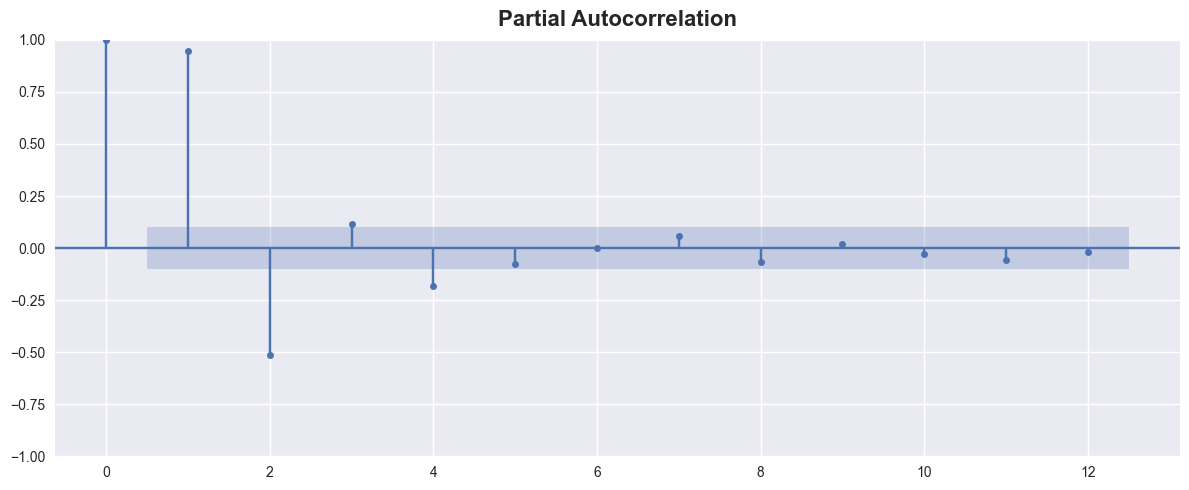

In [163]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(flu_trends.FluVisits, lags=12)

In [164]:


def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)





In previous lessons, we were able to create forecasts for as many steps as we liked beyond the training data. When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

We'll see strategies for handling this problem in Lesson 6. For this example, we'll just use a values from a test set.


In [175]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = flu_trends.FluVisits.copy()

#  train_test_split splits arrays or matrices into random subsets for train and test data, respectively.
# sklearn.model_selection.train_test_split(
#     *arrays,
#     test_size=None,
#     train_size=None,
#     random_state=None,
#     shuffle=True,
#     stratify=None
# )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)


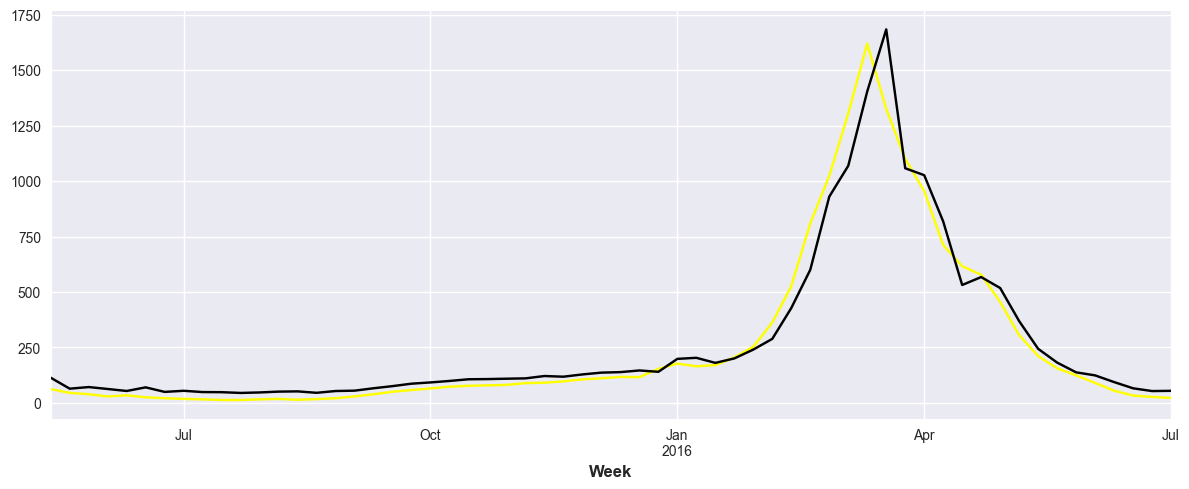

In [192]:
# ax = y_train.plot(color='blue', label='y train')
# ax = y_pred.plot(color='red', label='y prediction')

ax = y_test.plot(color='yellow', label='y test')
_ = y_fore.plot(ax=ax, color='black', label='y fore')

plt.show()



Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.


**To improve the forecast we could try to find leading indicators, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.**

<Axes: xlabel='Week'>

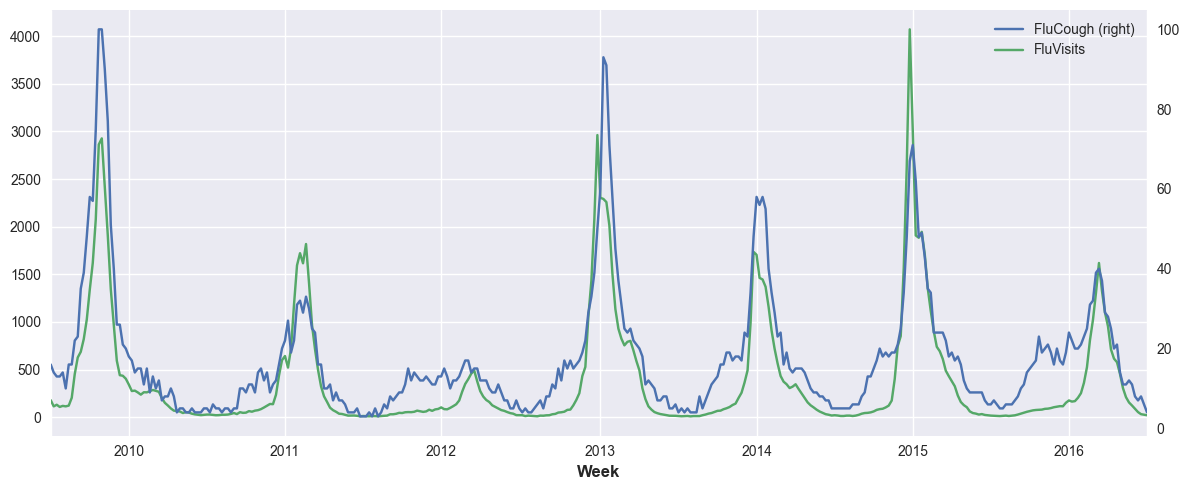

In [213]:
flu_trends.plot(
    y=['FluCough', 'FluVisits'],
    secondary_y='FluCough' # creates a secondary y axis in scale of the first y axis to be more comparable
)


In [221]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]
X1 = make_lags(flu_trends['FluVisits'], lags=4)
X = pd.concat([X0, X1], axis=1).fillna(0.0)

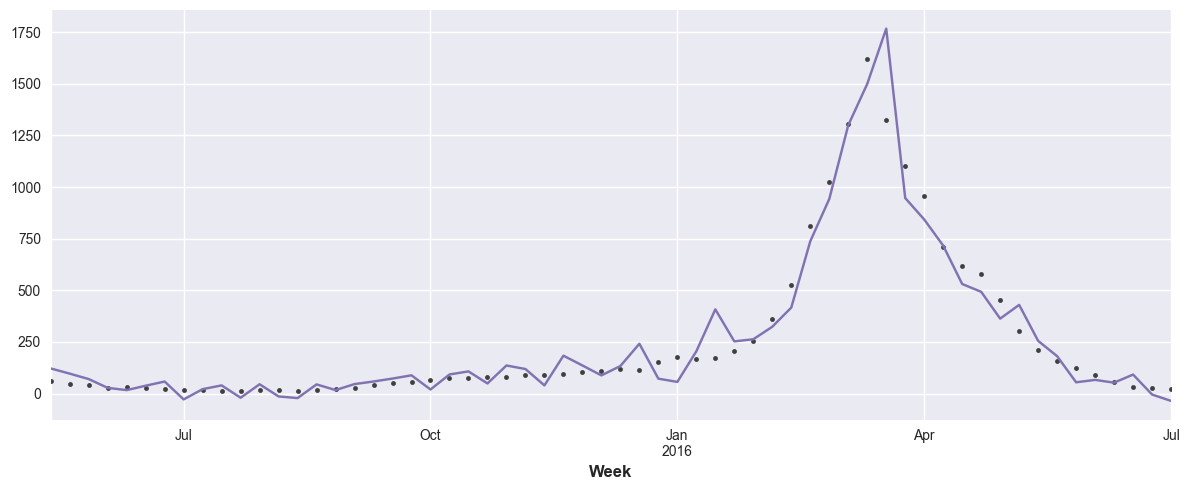

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')



Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.


# HYBRID MODELS

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor



# Set Matplotlib defaults
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)


industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    "../resources/us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [4]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2730474713.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2730474713.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2730474713.py:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


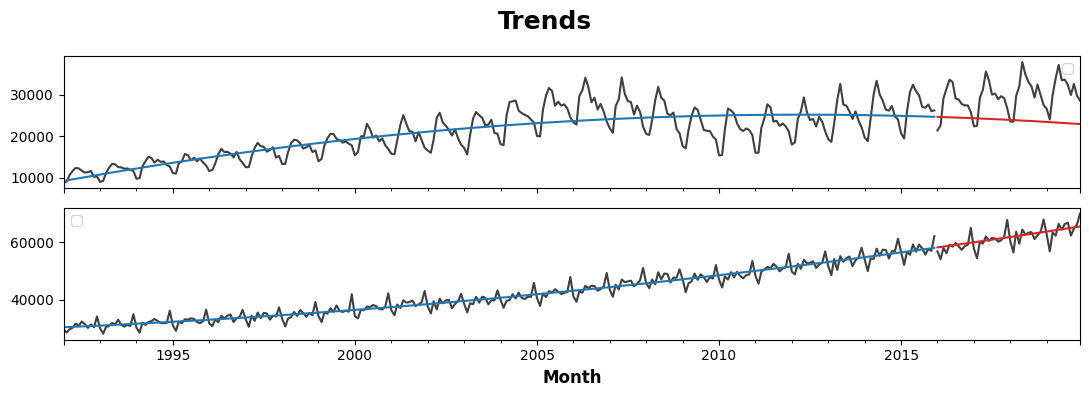

In [5]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


In [6]:
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [7]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]


In [8]:
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred


/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2192305118.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.unstack(['Industries']).plot(
/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2192305118.py:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack(['Industries']).plot(
/var/folders/g6/vgc6wxj13x95m3zxhrn480540000gn/T/ipykernel_1940/2192305118.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack(['Industries']).plot(


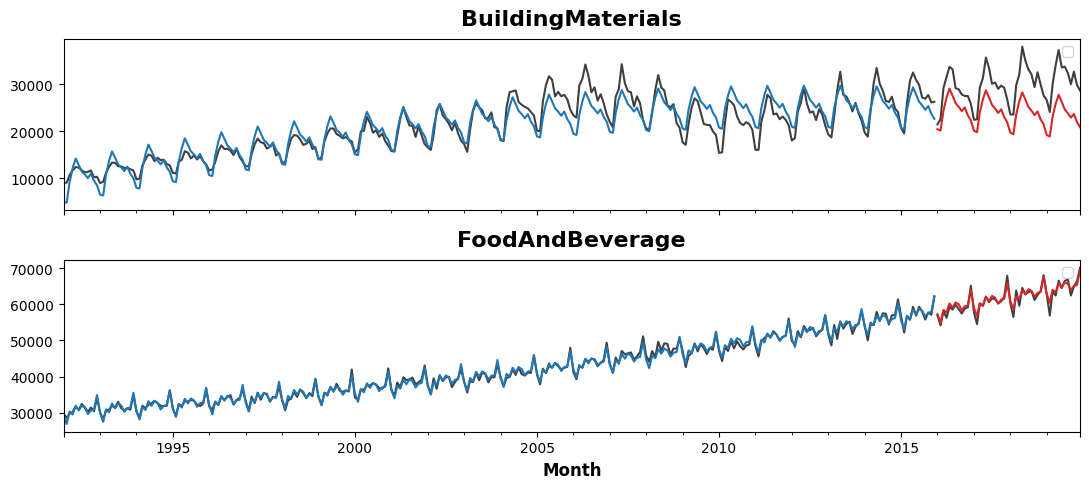

In [9]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])